In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
from datetime import datetime

current_datetime = datetime.now()
print(current_datetime)

2024-05-04 18:57:17.723605


### 1. Preprocess the MNIST dataset and read the data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [19]:
# Download and load the training data
trainset = datasets.MNIST('./dataset/train', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./dataset/test', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# Split the training data into training set and validation set
val_size = int(0.1 * len(trainset))  # 10% for validation set
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./Desktop/mnist classification/dataset/test', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

##### out of memory - reduce the training set to 1000 samples

In [4]:
# out of memory - cut the training set to 1000 samples
from torch.utils.data import Subset

# Define the number of samples for debugging
num_samples = 500

# Download and load the training data
trainset = datasets.MNIST('./dataset/train', download=False, train=True, transform=transform)
trainset = Subset(trainset, range(num_samples))  # Use only the first num_samples samples
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./dataset/test', download=False, train=False, transform=transform)
testset = Subset(testset, range(num_samples))  # Use only the first num_samples samples
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Split the training data into training set and validation set
val_size = int(0.1 * len(trainset))  # 10% for validation set
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

#### Dataset website link:  http://yann.lecun.com/exdb/mnist/

### 2. Define the GoogLeNet model

In [5]:
import torch
from torchvision import models

# Define the GoogLeNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        # Load a pre-trained version of GoogLeNet
        self.googlenet = models.googlenet(pretrained=True)
        # Replace the last fully-connected layer
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.googlenet.fc.in_features
        self.googlenet.fc = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.googlenet(x)
        return x

### 3. Model summary

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = GoogLeNet(num_classes=10).to(device)
summary(googlenet, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

### 4. Train and visulization of the googlenet model

Epoch 1/50 | Training loss: 2.3592951595783234 | Validation loss: 2.343841075897217 | Training accuracy: 8.222222222222221% | Validation accuracy: 12.0%
Epoch 2/50 | Training loss: 2.23492494225502 | Validation loss: 2.2830755710601807 | Training accuracy: 19.333333333333332% | Validation accuracy: 8.0%
Epoch 3/50 | Training loss: 2.0729264467954636 | Validation loss: 2.1698415279388428 | Training accuracy: 34.888888888888886% | Validation accuracy: 14.0%
Epoch 4/50 | Training loss: 1.9623860567808151 | Validation loss: 2.131216049194336 | Training accuracy: 37.111111111111114% | Validation accuracy: 10.0%
Epoch 5/50 | Training loss: 1.747516855597496 | Validation loss: 1.9118252992630005 | Training accuracy: 49.55555555555556% | Validation accuracy: 42.0%
Epoch 6/50 | Training loss: 1.654398798942566 | Validation loss: 1.8552067279815674 | Training accuracy: 60.888888888888886% | Validation accuracy: 48.0%
Epoch 7/50 | Training loss: 1.5115662664175034 | Validation loss: 1.63420069217

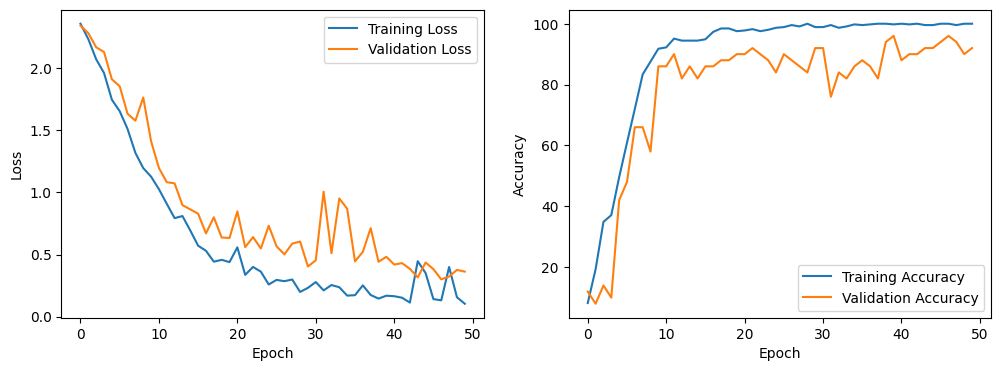

In [8]:
# Initialize the GoogLeNet model and move it to the GPU if available
googlenet = GoogLeNet(num_classes=10).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to hold the losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the patience and the counter for early stopping
# add early stopping to prevent overfitting during model training
patience = 30
early_stopping_counter = 0

# Initialize the minimum validation loss to a large value
min_val_loss = float('inf')

# Train the model
epochs = 50
for epoch in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    googlenet.train()  # Set the model to training mode
    for inputs, labels in trainloader:
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()
    else:
        # Save the loss and accuracy for this epoch
        train_losses.append(running_loss/len(trainloader))
        train_accuracies.append(100 * correct_train / total_train)
        
        # Validation
        googlenet.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = googlenet(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(valloader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check if the validation loss is the lowest so far
        if val_loss < min_val_loss:
            # If so, save the model and update the minimum validation loss
            torch.save(googlenet.state_dict(), 'best_model_GoogLeNet.pth')
            min_val_loss = val_loss
            early_stopping_counter = 0
        else:
        # If not, increment the counter
            early_stopping_counter += 1
            print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
            if early_stopping_counter >= patience:
                print('Early stopping')
                break  # Stop the training

        # Print the loss and accuracy for this epoch in one line
        print(f"Epoch {epoch+1}/{epochs} | Training loss: {running_loss/len(trainloader)} | Validation loss: {val_loss} | Training accuracy: {100 * correct_train / total_train}% | Validation accuracy: {val_accuracy}%")

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5. Calculate the accuracy of the model on the total test set

In [9]:
# Load the best model
googlenet.load_state_dict(torch.load('best_model_GoogLeNet.pth'))

googlenet.eval()  # Set the model to evaluation mode

correct = 0
total = 0

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 93 %


### 6. Calculate the accuracy of the model on the total test set for each class


In [10]:
# 得到每一个类别的准确率

googlenet.load_state_dict(torch.load('best_model_GoogLeNet.pth'))

# Set the model to evaluation mode
googlenet.eval()

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    if class_total[i] != 0:
        print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Accuracy of %5s : N/A' % i)


Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 80 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 75 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %
